# 1. Importing Libraries 

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 2. Loading Dataset

In [2]:
df = pd.read_csv('dataset/cirrhosis.csv')

# 3. Data Preprocessing 

In [3]:
# Handling missing values
df.fillna(0, inplace=True)  # You may want to use more advanced imputation techniques

# Encoding categorical variables (if any)
# For example, if 'Sex' is a categorical variable:
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)

# Standardize/Normalize numerical features
scaler = StandardScaler()
numerical_cols = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           418 non-null    object 
 4   Age            418 non-null    float64
 5   Ascites        418 non-null    object 
 6   Hepatomegaly   418 non-null    object 
 7   Spiders        418 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    418 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         418 non-null    float64
 13  Alk_Phos       418 non-null    float64
 14  SGOT           418 non-null    float64
 15  Tryglicerides  418 non-null    float64
 16  Platelets      418 non-null    float64
 17  Prothrombin    418 non-null    float64
 18  Stage     

### Mapping all categorical variables to numeric values for ANN 

In [5]:
df['Ascites'] =df['Ascites'].map({'Y': 1, 'N': -1, 0 : 0 })

In [6]:
df['Hepatomegaly']=df['Hepatomegaly'].map({'Y': 1, 'N': -1, 0 : 0})

In [7]:
df['Spiders']=df['Spiders'].map({'Y': 1, 'N': -1, 0 : 0})

In [8]:
df['Edema']=df['Edema'].map({'Y': 1, 'N': -1, 'S':0})

In [9]:
df['Sex_M']=df['Sex_M'].map({True : 1, False : 0})

In [10]:
df['Drug']=df['Drug'].map({'D-penicillamine': 1, 'Placebo': -1, 0 : 0})

# 4. EDA 

## i) Age Distribution

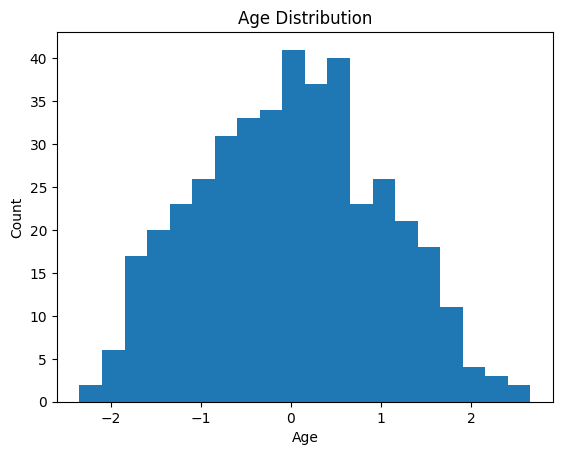

In [11]:
# Plot age distribution
plt.hist(df['Age'], bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

## ii) Bilirubin vs. Cholesterol 

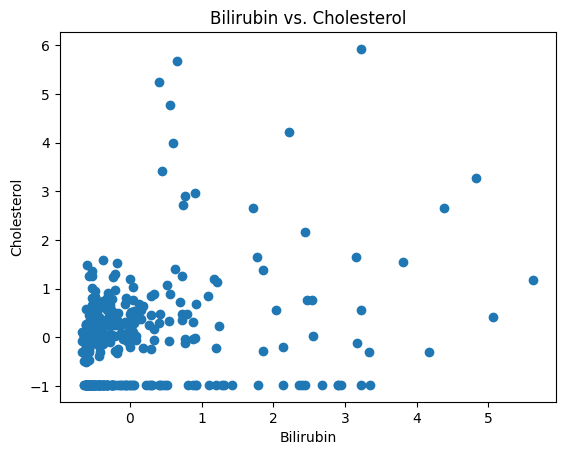

In [12]:
plt.scatter(df['Bilirubin'], df['Cholesterol'])
plt.xlabel('Bilirubin')
plt.ylabel('Cholesterol')
plt.title('Bilirubin vs. Cholesterol')
plt.show()

## iii) Kaplan - Meir Survival Curve 

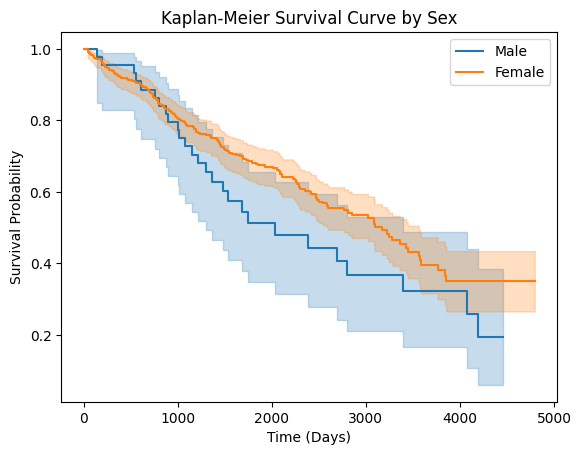

In [13]:
kmf = KaplanMeierFitter()

# Example: Kaplan-Meier curve based on 'Sex'
# Map 'Status' to numeric values
df['Event_Status'] = df['Status'].map({'D': 1, 'C': 0, 'CL': -1})

# Now use 'Event_Status' for event_observed
event_data = df[df['Sex_M'] == 1]
event_observed = event_data['Event_Status']

kmf.fit(durations=event_data['N_Days'], event_observed=event_observed)
kmf.plot(label='Male')


# Map 'Status' to numeric values
df['Event_Status'] = df['Status'].map({'D': 1, 'C': 0, 'CL': -1})

# Now use 'Event_Status' for event_observed
event_data = df[df['Sex_M'] == 0]
event_observed = event_data['Event_Status']

kmf.fit(durations=event_data['N_Days'], event_observed=event_observed)
kmf.plot(label='Female')

plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curve by Sex')
plt.legend()
plt.show()

## iv) Log Rank Test 

In [14]:
drug_A_data = df[df['Drug'] == 1]
drug_B_data = df[df['Drug'] == -1]

results = logrank_test(drug_A_data['N_Days'], drug_B_data['N_Days'], event_observed_A=drug_A_data['Status'], event_observed_B=drug_B_data['Status'])

print(f"Log-rank p-value: {results.p_value}")

Log-rank p-value: 0.9868635548166224


## v) Survival Probability Heatmap 

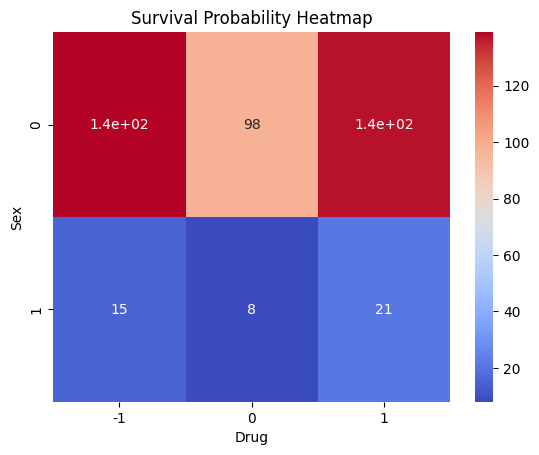

In [15]:
# Example: Create a survival probability heatmap based on 'Sex' and 'Drug'
pivot_df = df.pivot_table(index='Sex_M', columns='Drug', values='N_Days', aggfunc='count')

sns.heatmap(pivot_df, cmap='coolwarm', annot=True)
plt.title('Survival Probability Heatmap')
plt.xlabel('Drug')
plt.ylabel('Sex')
plt.show()

# 5. Defining Target Variable 

In [16]:
time_to_event = df['N_Days'].values
event_indicator = (df['Status'] == 'D').astype(int).values

# 6. Splitting Dataset 

In [17]:
X_train, X_test, time_train, time_test, event_train, event_test = train_test_split(
    df.drop(['N_Days', 'Status'], axis=1), time_to_event, event_indicator, test_size=0.2, random_state=42)

In [18]:
# Convert NumPy arrays to TensorFlow tensors
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
time_train_tf = tf.convert_to_tensor(time_train, dtype=tf.float32)

# 7. Model Building & Compiling

In [67]:
# Build the ANN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Linear activation for survival analysis
])
model.compile(optimizer='adagrad', loss='mean_squared_error')

# 8. Model Training 

In [78]:
history = model.fit(X_train, time_train, epochs=5000, verbose=0)

# 9. Model Predictions 

In [79]:
predicted_survival_times = model.predict(X_test).flatten()

3/3 [==============================] - 0s 3ms/step


In [80]:
# Evaluate the model using lifelines concordance index
c_index = concordance_index(event_test, -predicted_survival_times, time_test)
print(f"Concordance Index: {c_index}")

Concordance Index: 0.7505787037037037


# 10. Model Performance Evaluation

In [81]:
#Define the event prediction threshold (e.g., 0.5)
threshold = 0.5
predicted_event = (predicted_survival_times > threshold).astype(int)

In [85]:
# 3. Calculate binary classification metrics
accuracy = accuracy_score(event_test, predicted_event)
precision = precision_score(event_test, predicted_event)
recall = recall_score(event_test, predicted_event)
f1 = f1_score(event_test, predicted_event)
roc_auc = roc_auc_score(event_test, predicted_survival_times)

In [87]:
print(f"Accuracy: {accuracy:.2f}")
print(f"\nPrecision: {precision:.2f}")
print(f"\nRecall: {recall:.2f}")
print(f"\nF1 Score: {f1:.2f}")
print(f"\nROC AUC Score: {roc_auc:.2f}")

Accuracy: 0.43

Precision: 0.43

Recall: 1.00

F1 Score: 0.60

ROC AUC Score: 0.25
